In [1]:
import numpy as np

from matplotlib import pyplot as plt
from docplex.mp.model import Model

In [2]:
def optimize_energy(
    solar_profile, load_assignation, batt_cap=6.5, alpha_high=0.5, alpha_low=0.5, alpha_diff=0.8,
    load_smoothness=0.15
):

    # Compute high low proportion

    proportion_high = sum([1 for l in load_assignation if l == 'high']) / len(load_assignation[load_assignation != 'none'])
    proportion_low = sum([1 for l in load_assignation if l == 'low']) / len(load_assignation[load_assignation != 'none'])

    model = Model(name='self_sufficient_day')

    # Define the decision variables
    load_high = model.continuous_var_list(24, name='load_h', lb=0)
    load_low = model.continuous_var_list(24, name='load_l', lb=0)
    batt = model.continuous_var_list(24, name='batt', lb=-1, ub=1)
    soc = model.continuous_var_list(24, name='soc', lb=0, ub=1)

    # Add constraints
    total_generation = solar_profile.sum()

    # Energy balance
    for i in range(24):
        model.add_constraint(load_high[i] + load_low[i] + batt[i] * batt_cap == solar_profile[i])

    # Battery
    model.add_constraint(soc[0] == 0)  # Initial state of charge
    model.add_constraint(soc[23] == 0)  # Final state of charge

    # Charge and discharge
    for i in range(24):
        model.add_constraint(soc[i] == soc[i-1] + batt[i])

    # Load assignation
    for i in range(24):
        if load_assignation[i] == 'none':
            model.add_constraint(load_high[i] == 0)
            model.add_constraint(load_low[i] == 0)
        elif load_assignation[i] == 'low':
            model.add_constraint(load_low[i] <= alpha_low * proportion_low * total_generation)
            model.add_constraint(load_high[i] == 0)
        elif load_assignation[i] == 'high':
            model.add_constraint(load_high[i] <= alpha_high * proportion_high * total_generation)
            model.add_constraint(load_low[i] == 0)

    # Conditions for high and low load
    model.add_constraint(model.sum(load_high) == proportion_high * total_generation)
    model.add_constraint(model.sum(load_low) == proportion_low * total_generation)
    model.add_constraint(model.max(load_high) * alpha_diff >= model.max(load_low))

    # Smoothness of the load

    for i in range(1, 24):
        model.add_constraint(
            model.abs((load_high[i] + load_low[i]) - (load_high[i-1] + load_low[i-1])) <= load_smoothness * total_generation
        )

    # Define the objective function
    obj = model.sum(load_high[i] + load_low[i] + batt[i] * batt_cap - solar_profile[i] for i in range(24))
    model.minimize(obj)

    # Solve the model
    model.solve(log_output=False)

    # Prepare solution
    sol = {
        'load_h': np.zeros(24),
        'load_l': np.zeros(24),
        'batt': np.zeros(24),
        'soc': np.zeros(24)
    }

    for v in model.iter_continuous_vars():
        if v.name is not None:
            index = int(v.name.split('_')[-1])
            if v.name.startswith('load_h'):
                sol['load_h'][index] = v.solution_value
            if v.name.startswith('load_l'):
                sol['load_l'][index] = v.solution_value
            if v.name.startswith('batt'):
                sol['batt'][index] = v.solution_value
            if v.name.startswith('soc'):
                sol['soc'][index] = v.solution_value

    return sol


In [3]:
def plot_energy_solution(sol, solar_generation, batt_cap=6.5):
    fig, ax1 = plt.subplots()

    ax1.plot(sol['load_h'] + sol['load_l'], label='Load', marker='o')
    ax1.plot(sol['batt'], label='Battery charge', marker='o')
    ax1.plot(solar_generation, label='Solar generation', marker='o')
    ax1.plot(sol['load_h'] + sol['load_l'] + sol['batt'] * batt_cap - solar_generation, label='Total energy', color='m', linestyle='--', marker='o')

    ax2 = ax1.twinx()
    ax2.plot(sol['soc'], label='State of charge', color='tab:red', marker='o')

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Energy (kWh)')
    ax2.set_ylabel('State of Charge')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax1.grid()

    plt.xticks(range(0, 24))
    plt.show()

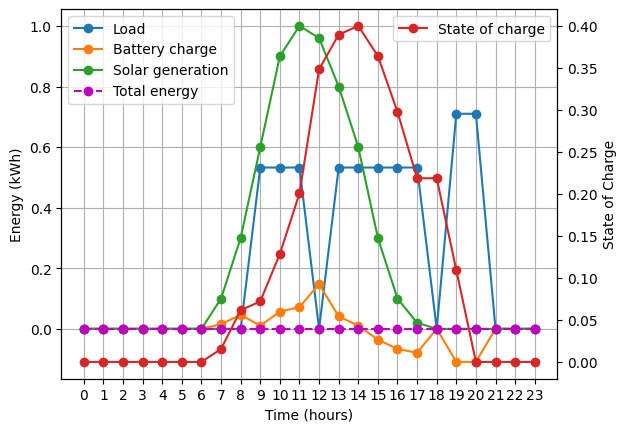

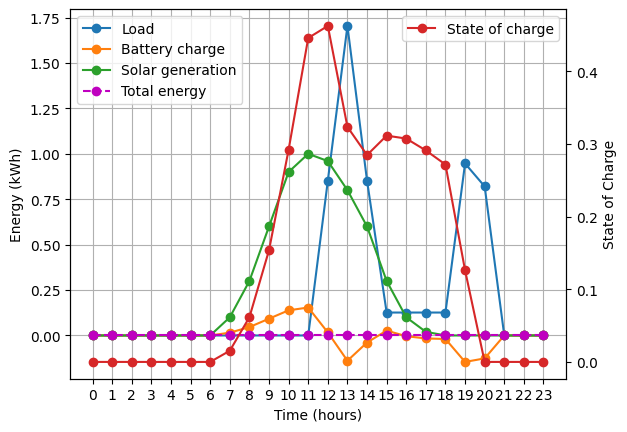

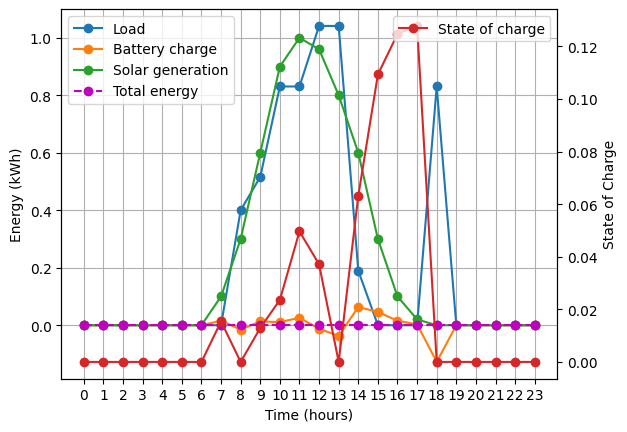

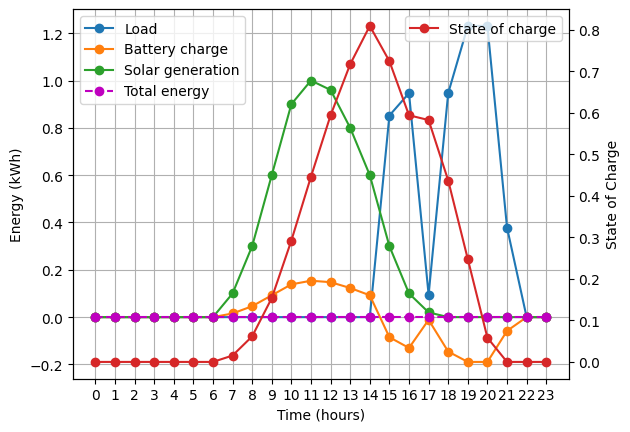

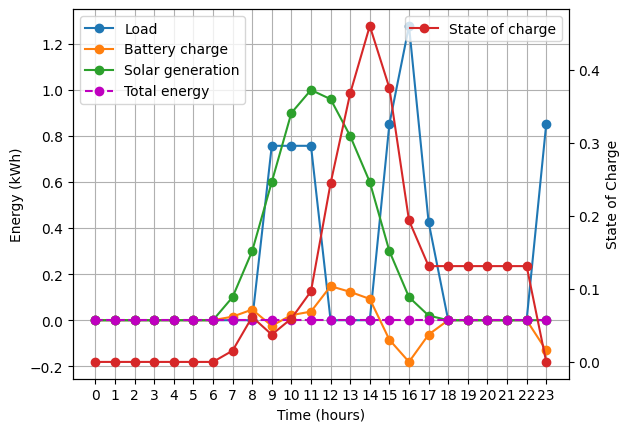

In [437]:
# Define solar energy generation values (in kWh) for each hour

solar_generation = np.array([0, 0, 0, 0, 0, 0, 0, 0.5, 1.5, 3.0, 4.5, 5.0, 4.8, 4.0, 3.0, 1.5, 0.5, 0.1, 0, 0, 0, 0, 0, 0]) * 200

# solar_generation = np.array([  0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
#           0.     ,  13.82083,  58.45417,  91.12083, 103.21667,  90.8125 ,
#          96.45834, 239.975  , 162.25833, 415.49167, 294.30417, 153.09166,
#          17.27917,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ])

solar_generation /= 1000

# Define an assignation of energy consumption by levels

load_assignations = np.array([
    ['none', 'none', 'none', 'low', 'low', 'low', 'high', 'none'],
    ['none', 'none', 'none', 'none', 'high', 'high', 'low', 'none'],
    ['none', 'none', 'low', 'low', 'high', 'high', 'low', 'none'],
    ['none', 'none', 'none', 'none', 'none', 'low', 'high', 'high'],
    ['none', 'none', 'none', 'low', 'low', 'high', 'high', 'high'],
])
batt_cap = 6.5

for load_assignation in load_assignations:

    load_assignation = np.array([[l] * 3 for l in load_assignation]).flatten()
    sol = optimize_energy(solar_generation, load_assignation)
    plot_energy_solution(sol, solar_generation, batt_cap)

In [5]:
import os
import json

import numpy as np
import pandas as pd

from pathlib import Path
from citylearn.data import DataSet
from pyparsing import col

def generate_optimal_data_from_ref(
    base_dataset: str = 'citylearn_challenge_2022_phase_all', dest_folder: str = 'data/opt_data/',
    load_assignations: list = None
):

    # Make sure the destination folder exists including the subfolders

    Path(dest_folder).mkdir(parents=True, exist_ok=True)

    # Get reference schema

    schema = DataSet.get_schema(base_dataset)

    # Reduce the number of buildings to 1

    schema['buildings'] = {f'Building_{i}': schema['buildings'][f'Building_{i}'] for i in range(1, 6)}

    # Extract the base weather, emissions and pricing data (doesn't change among buildings)

    base_weather = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['weather']))
    base_pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))
    base_emissions = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['carbon_intensity']))

    # Read the base schema and process the json

    # We need just to store the load and optimal actions for each building
    # 0 - Load
    # 1 - Battery charge/discharge
    # 2 - SoC


    building_data = np.array([[[0.] * 3 for _ in range(365 * 24)] for _ in range(5)])
    base_csvs = []

    for building_no, (building_name, info) in enumerate(schema['buildings'].items()):

        # Create custom building CSVs

        base_csv = pd.read_csv(os.path.join(schema['root_directory'], info['energy_simulation']))
        solar_generation = base_csv['solar_generation'].values / 1000

        base_csvs.append(base_csv)

        # Pass one day at a time the solar generation from the building data

        for day in range(365):
            
            # print(f'Building {building_no} - Day {day}')

            load_assignation = load_assignations[building_no]
            batt_cap = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

            sol = optimize_energy(solar_generation[day * 24:(day + 1) * 24], load_assignation, batt_cap)

            building_data[building_no, day * 24:(day + 1) * 24, 0] += sol['load_h'] + sol['load_l']
            building_data[building_no, day * 24:(day + 1) * 24, 1] += sol['batt']
            building_data[building_no, day * 24:(day + 1) * 24, 2] += sol['soc']

    # Update the base csv with the new data

    for building_no, (building_name, _) in enumerate(schema['buildings'].items()):

        base_csvs[building_no]['non_shiftable_load'] = building_data[building_no,:,0].clip(min=0)
        base_csvs[building_no].to_csv(os.path.join(dest_folder, f'{building_name}.csv'), index=False)

        # Save batt action and soc in a separate file to avoid issues loading CityLearn

        sol_csv = pd.DataFrame(columns=['batt', 'soc'], index=range(365 * 24))

        sol_csv['batt'] = building_data[building_no,:,1]
        sol_csv['soc'] = building_data[building_no,:,2]

        sol_csv.to_csv(os.path.join(dest_folder, f'sol_{building_no}_optimal.csv'), index=False)

        # Update the schema with the new paths

        schema['buildings'][building_name]['energy_simulation'] = f'{building_name}.csv'

        # Update the schema to guarantee no degradation in the battery efficiency

        schema['buildings'][building_name]['electrical_storage']['attributes'] = {
            "capacity": 6.4,
            "efficiency": 1,
            "capacity_loss_coefficient": 0.0,
            "loss_coefficient": 0.0,
            "nominal_power": 5.0,
            "power_efficiency_curve": [[0, 1],[0.3, 1],[0.7, 1],[0.8, 1],[1, 1]],
            "capacity_power_curve": [[0.0, 1],[0.8, 1],[1.0, 1]],
        }

        # Set nominal power to 1 for solar panel to simplify case

        schema['buildings'][building_name]['pv']['attributes']['nominal_power'] = 1.0

    # Write pricing and emissions data to the destination folder

    base_weather.to_csv(os.path.join(dest_folder, 'weather.csv'), index=False)
    base_pricing.to_csv(os.path.join(dest_folder, 'pricing.csv'), index=False)
    base_emissions.to_csv(os.path.join(dest_folder, 'carbon_intensity.csv'), index=False)

    # Save the new schema in the destination folder

    schema['root_directory'] = dest_folder

    with open(os.path.join(dest_folder, 'schema.json'), 'w') as f:
        json.dump(schema, f, indent=4)

In [439]:
# Define an assignation of energy consumption by levels
# ['none', 'none', 'none', 'none', 'low', 'high', 'low', 'high'],

load_assignations = [
    ['none', 'none', 'none', 'low', 'low', 'low', 'high', 'none'],
    ['none', 'none', 'none', 'none', 'high', 'high', 'low', 'none'],
    ['none', 'none', 'low', 'low', 'high', 'high', 'low', 'none'],
    ['none', 'none', 'none', 'none', 'none', 'low', 'high', 'high'],
    ['none', 'none', 'none', 'low', 'low', 'high', 'high', 'high'],
]

for ix, load_assignation in enumerate(load_assignations):

    load_assignations[ix] = np.array([[l] * 3 for l in load_assignation]).flatten()

load_assignations = np.array(load_assignations)

generate_optimal_data_from_ref(load_assignations=load_assignations)
    

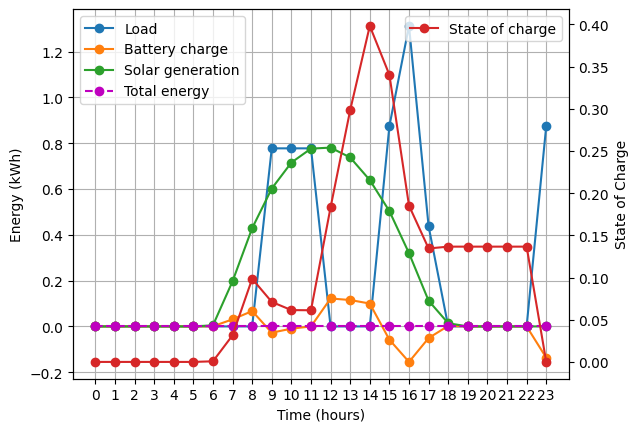

In [18]:
# Check data generated picking random days from random buildings

day_index = 5832
building_index = 4

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

building_name = f'Building_{building_index + 1}'
building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{building_index}_optimal.csv'))

solar_generation = building_csv['solar_generation'].values / 1000
load = building_csv['non_shiftable_load'].values
batt = sol_csv['batt'].values
soc = sol_csv['soc'].values
battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

plot_energy_solution({
    'load_h': load[day_index:day_index + 24],
    'load_l': np.zeros(24),
    'batt': batt[day_index:day_index + 24],
    'soc': soc[day_index:day_index + 24]
}, solar_generation[day_index:day_index + 24], battery_capacity)

In [467]:
# Check net energy of whole year

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(5):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{b_ix}_optimal.csv'))

    solar_generation = building_csv['solar_generation'].values / 1000
    load = building_csv['non_shiftable_load'].values
    batt = sol_csv['batt'].values
    soc = sol_csv['soc'].values
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values
    
    cost_no_batt = (net_energy_no_batt * pricing).mean()
    cost = (net_energy * pricing).mean()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).mean()
    emissions = (emissions * net_energy.clip(min=0)).mean()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt.mean()} - With batt: {emissions.mean()}')

Building 1
Avg. Hour Cost No batt: 0.01868840409854601 - With batt: 4.854039069473026e-18
Avg. Hour Emissions No batt: 0.01293895675120257 - With batt: 1.2026143198106106e-17
Building 2
Avg. Hour Cost No batt: 0.00883292462806422 - With batt: 1.1859085420413613e-17
Avg. Hour Emissions No batt: 0.014544251673045117 - With batt: 1.6432265160168046e-17
Building 3
Avg. Hour Cost No batt: 0.008593014192478928 - With batt: -5.661884457554816e-18
Avg. Hour Emissions No batt: 0.012079097703815744 - With batt: 9.793779259769313e-18
Building 4
Avg. Hour Cost No batt: 0.025332777611666853 - With batt: 3.753657252666645e-17
Avg. Hour Emissions No batt: 0.019007078294865924 - With batt: 2.3154201494219903e-17
Building 5
Avg. Hour Cost No batt: 0.008290699359931722 - With batt: 4.052197042585743e-18
Avg. Hour Emissions No batt: 0.014457034476539222 - With batt: 1.2313071088178041e-17


In [20]:
# Check net energy for a given period

day_index = 5832

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(5):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{b_ix}_optimal.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt * pricing).mean()
    cost = (net_energy * pricing).mean()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).mean()
    emissions = (emissions * net_energy.clip(min=0)).mean()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt.mean()} - With batt: {emissions.mean()}')

Building 1
Avg. Hour Cost No batt: 0.026244853186457747 - With batt: 2.297456026060148e-17
Avg. Hour Emissions No batt: 0.016264187201162406 - With batt: 2.0897804144350108e-17
Building 2
Avg. Hour Cost No batt: 0.00909236458424992 - With batt: -6.00142042543143e-18
Avg. Hour Emissions No batt: 0.01936662158247866 - With batt: 1.4816641940417163e-17
Building 3
Avg. Hour Cost No batt: 0.010997328790833311 - With batt: -1.7209324243427913e-17
Avg. Hour Emissions No batt: 0.01669540022011109 - With batt: 1.29171354255192e-17
Building 4
Avg. Hour Cost No batt: 0.03177771090734719 - With batt: 5.860040462139319e-17
Avg. Hour Emissions No batt: 0.023573259964681712 - With batt: 3.6137540262009635e-17
Building 5
Avg. Hour Cost No batt: 0.01574737780958334 - With batt: 2.62055279096988e-17
Avg. Hour Emissions No batt: 0.019366471278512303 - With batt: 1.740984848509821e-17


In [33]:
# Check net energy for a given period

day_index = 5832

with open('data/opt_data/schema.json', 'r') as f:
    schema = json.load(f)

for b_ix in range(5):

    building_name = f'Building_{b_ix + 1}'
    building_csv = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings'][building_name]['energy_simulation']))
    sol_csv = pd.read_csv(os.path.join(schema['root_directory'], f'sol_{b_ix}_optimal.csv'))

    solar_generation = building_csv['solar_generation'].values[day_index:day_index+24] / 1000
    load = building_csv['non_shiftable_load'].values[day_index:day_index+24]
    batt = sol_csv['batt'].values[day_index:day_index+24]
    soc = sol_csv['soc'].values[day_index:day_index+24]
    battery_capacity = schema['buildings'][building_name]['electrical_storage']['attributes']['capacity']

    # Compute net electricity

    net_energy_no_batt = load - solar_generation
    net_energy = load - solar_generation + batt * battery_capacity

    # Compute energy cost

    pricing = pd.read_csv(os.path.join(schema['root_directory'], schema['buildings']['Building_1']['pricing']))['electricity_pricing'].values[day_index:day_index+24]
    
    cost_no_batt = (net_energy_no_batt * pricing).mean()
    cost = (net_energy * pricing).mean()

    # Correct energy cost

    correct_cost_no_batt = (net_energy_no_batt.clip(min=0) * pricing + net_energy_no_batt.clip(max=0) * 0.9 * pricing).mean()
    correct_cost = (net_energy.clip(min=0) * pricing + net_energy.clip(max=0) * 0.9 * pricing).mean()

    # Compute carbon intensity

    emissions = pd.read_csv(os.path.join(schema['root_directory'], 'carbon_intensity.csv'))['carbon_intensity'].values[day_index:day_index+24]

    emissions_no_batt = (emissions * net_energy_no_batt.clip(min=0)).mean()
    emissions = (emissions * net_energy.clip(min=0)).mean()

    print(f'Building {b_ix + 1}')
    print(f'Avg. Hour Cost No batt: {cost_no_batt} - With batt: {cost}')
    print(f'Avg. Hour Correct Cost No batt: {correct_cost_no_batt} - With batt: {correct_cost}')
    print(f'Avg. Hour Emissions No batt: {emissions_no_batt.mean()} - With batt: {emissions.mean()}')

Building 1
Avg. Hour Cost No batt: 0.026244853186457747 - With batt: 2.297456026060148e-17
Avg. Hour Correct Cost No batt: 0.02832810454090778 - With batt: 2.5530964423032635e-17
Avg. Hour Emissions No batt: 0.016264187201162406 - With batt: 2.0897804144350108e-17
Building 2
Avg. Hour Cost No batt: 0.00909236458424992 - With batt: -6.00142042543143e-18
Avg. Hour Correct Cost No batt: 0.01254324176844159 - With batt: -3.444438021841615e-18
Avg. Hour Emissions No batt: 0.01936662158247866 - With batt: 1.4816641940417163e-17
Building 3
Avg. Hour Cost No batt: 0.010997328790833311 - With batt: -1.7209324243427913e-17
Avg. Hour Correct Cost No batt: 0.014346858147749978 - With batt: -1.2525773242696067e-17
Avg. Hour Emissions No batt: 0.01669540022011109 - With batt: 1.29171354255192e-17
Building 4
Avg. Hour Cost No batt: 0.03177771090734719 - With batt: 5.860040462139319e-17
Avg. Hour Correct Cost No batt: 0.035053411244194414 - With batt: 5.911156980564769e-17
Avg. Hour Emissions No batt: